## Concatenação dos DFs

In [24]:
kepler_data = kepler_data[k2_data.columns]
tess_data = tess_data[k2_data.columns]

In [26]:
general_data = pd.concat([k2_data,kepler_data],axis=0)
general_data = pd.concat([general_data,tess_data],axis=0)

In [27]:
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20364 entries, 0 to 7026
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   classification       20362 non-null  object 
 1   longitude_s          20364 non-null  object 
 2   longitude            20364 non-null  float64
 3   latitude_s           20364 non-null  object 
 4   latitude             20364 non-null  float64
 5   stellar_temperature  18767 non-null  float64
 6   stellar_radius       19411 non-null  float64
 7   planet_radius        18776 non-null  float64
 8   eq_temperature       16649 non-null  float64
 9   distance             19674 non-null  float64
 10  stellar_sur_gravity  17584 non-null  float64
 11  orbital_period       20225 non-null  float64
 12  insol_flux           16627 non-null  float64
 13  depth                19203 non-null  float64
 14  mission              20364 non-null  object 
dtypes: float64(11), object(4)
memory usage: 2.

In [28]:
colunas_dados_faltantes = ['stellar_temperature','stellar_radius','planet_radius','eq_temperature','distance','stellar_sur_gravity','orbital_period','insol_flux','depth']

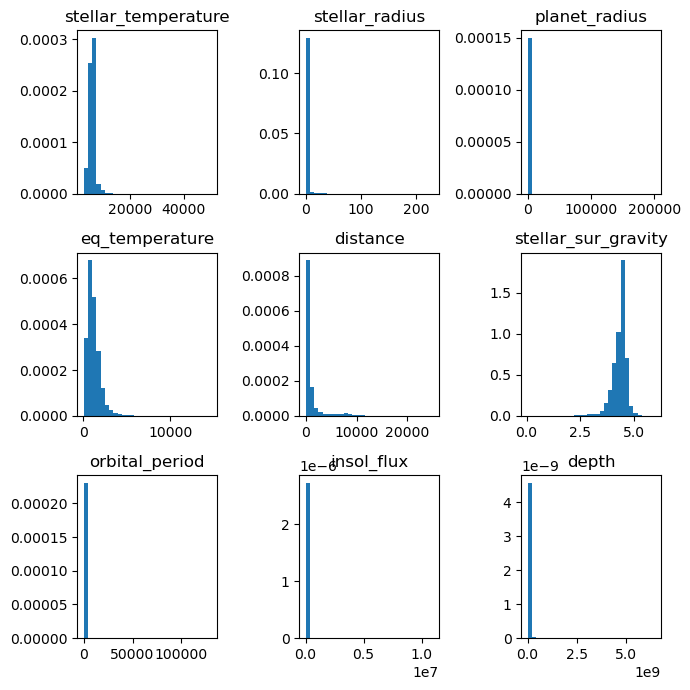

In [29]:
fig,ax = plt.subplots(3,3,figsize = (7,7),dpi = 100)
ax[0,0].hist(general_data.stellar_temperature,bins = 30,density = True)
ax[0,0].set_title('stellar_temperature')
ax[0,1].hist(general_data.stellar_radius,bins = 30,density = True)
ax[0,1].set_title('stellar_radius')
ax[0,2].hist(general_data.planet_radius,bins = 30,density = True)
ax[0,2].set_title('planet_radius')
ax[1,0].hist(general_data.eq_temperature,bins = 30,density = True)
ax[1,0].set_title('eq_temperature')
ax[1,1].hist(general_data[general_data.distance!=np.inf].distance,bins = 30,density = True) ## adicionei um filtro nesse plot, pois há dados de distance iguais a infinito
ax[1,1].set_title('distance')
ax[1,2].hist(general_data.stellar_sur_gravity,bins = 30,density = True)
ax[1,2].set_title('stellar_sur_gravity')
ax[2,0].hist(general_data.orbital_period,bins = 30,density = True)
ax[2,0].set_title('orbital_period')
ax[2,1].hist(general_data.insol_flux,bins = 30,density = True)
ax[2,1].set_title('insol_flux')
ax[2,2].hist(general_data.depth,bins = 30,density = True)
ax[2,2].set_title('depth')

plt.tight_layout()

somente `stellar_sur_gravity` pode ser considerado normal visualmente... a `eq_temperature` e `stellar_temperature` também parecem um pouco normais, mas pela largura do eixo x, temos a indicação de muitos outliers... Para facilitar, vamos imputar todos os faltantes com valor aleatório homogêneo baseado na distância interquartil das variáveis. Detalhe: vamos imputar também os valores infinitos da variável `distance`, pois também não podemos submeter valores tipo infinito para os algoritmos de ML

Precisamos lembrar que, após a imputação, a distribuição dos dados não pode ser afetada. Para isso, vamos comparar os describes de antes e depois das imputações para garantir isso

In [30]:
def impute_random(df, column_name):
    # Calcula quartis inferiores e superiores
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    
    # Calcula a amplitude interquartil
    iqr = q3 - q1
    
    # Calcula os limites para valores dentro do intervalo interquartil
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Filtra os valores não nulos dentro do intervalo interquartil
    non_null_values = df[column_name].loc[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    # Impute os valores faltantes com valores aleatórios homogêneos
    missing_count = df[column_name].isnull().sum()
    imputed_values = np.random.uniform(q1, q3, missing_count)
    dfx = df.copy()
    # Atualiza os valores faltantes no DataFrame
    dfx.loc[dfx[column_name].isnull(), column_name] = imputed_values
    
    return dfx

Exemplo de imputação com a `stellar_temperature`

In [31]:
dfx = impute_random(general_data,colunas_dados_faltantes[0])   


In [32]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20364 entries, 0 to 7026
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   classification       20362 non-null  object 
 1   longitude_s          20364 non-null  object 
 2   longitude            20364 non-null  float64
 3   latitude_s           20364 non-null  object 
 4   latitude             20364 non-null  float64
 5   stellar_temperature  20364 non-null  float64
 6   stellar_radius       19411 non-null  float64
 7   planet_radius        18776 non-null  float64
 8   eq_temperature       16649 non-null  float64
 9   distance             19674 non-null  float64
 10  stellar_sur_gravity  17584 non-null  float64
 11  orbital_period       20225 non-null  float64
 12  insol_flux           16627 non-null  float64
 13  depth                19203 non-null  float64
 14  mission              20364 non-null  object 
dtypes: float64(11), object(4)
memory usage: 2.

In [33]:
general_data.stellar_temperature.describe()

count    18767.000000
mean      5658.610170
std       1194.915631
min       2520.000000
25%       5172.850000
50%       5722.000000
75%       6131.000000
max      50000.000000
Name: stellar_temperature, dtype: float64

In [34]:
dfx.stellar_temperature.describe()

count    20364.000000
mean      5659.174525
std       1149.677189
min       2520.000000
25%       5225.000000
50%       5714.000000
75%       6099.000000
max      50000.000000
Name: stellar_temperature, dtype: float64

Generalizando

In [35]:
dfx = general_data.copy()
for coluna in colunas_dados_faltantes:
    dfx = impute_random(dfx,coluna)

In [36]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20364 entries, 0 to 7026
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   classification       20362 non-null  object 
 1   longitude_s          20364 non-null  object 
 2   longitude            20364 non-null  float64
 3   latitude_s           20364 non-null  object 
 4   latitude             20364 non-null  float64
 5   stellar_temperature  20364 non-null  float64
 6   stellar_radius       20364 non-null  float64
 7   planet_radius        20364 non-null  float64
 8   eq_temperature       20364 non-null  float64
 9   distance             20364 non-null  float64
 10  stellar_sur_gravity  20364 non-null  float64
 11  orbital_period       20364 non-null  float64
 12  insol_flux           20364 non-null  float64
 13  depth                20364 non-null  float64
 14  mission              20364 non-null  object 
dtypes: float64(11), object(4)
memory usage: 2.

In [37]:
for coluna in colunas_dados_faltantes:
    print(f'comparação da coluna {coluna}')
    print(general_data[coluna].describe())
    print(dfx[coluna].describe())

comparação da coluna stellar_temperature
count    18767.000000
mean      5658.610170
std       1194.915631
min       2520.000000
25%       5172.850000
50%       5722.000000
75%       6131.000000
max      50000.000000
Name: stellar_temperature, dtype: float64
count    20364.000000
mean      5658.284813
std       1149.753193
min       2520.000000
25%       5222.000000
50%       5711.151270
75%       6100.000000
max      50000.000000
Name: stellar_temperature, dtype: float64
comparação da coluna stellar_radius
count    19411.00000
mean         1.51890
std          4.46347
min          0.10900
25%          0.81250
50%          1.02200
75%          1.47000
max        229.90800
Name: stellar_radius, dtype: float64
count    20364.000000
mean         1.500511
std          4.358757
min          0.109000
25%          0.820000
50%          1.030000
75%          1.440734
max        229.908000
Name: stellar_radius, dtype: float64
comparação da coluna planet_radius
count     18776.000000
mean       

In [8]:
# kepler_data.to_pickle('data\\kepler_data_treated.pkl')
# k2_data.to_pickle('data\\k2_data_treated.pkl')
# tess_data.to_pickle('data\\tess_data_treated.pkl')